# **Homework 2 Problem 3: Bringing It All Together**

In this problem, you'll be getting some practice designing an end-to-end Machine Learning pipeline for predicting sentiment of tweets in the twitter dataset. Like a real-world data science problem, you'll be preparing your data, performing hyperparamater tuning, evaluating different models using different metrics, and writing up your results.

# 0 Loading Data and Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import datasets
# Remember you have to run this cell block before continuing!

# We will use this random seed throughout to make things more deterministic for testing
random_seed = 25

# 1 Complete Pipeline

## 1.1 Loading the Data

In this problem you will learn to calculate accuracy, precision, recall and f1-score for a classifier.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

raw_data = pd.read_csv('./hw2_p3.csv')
raw_data

,Unnamed: 0,polarity,id,date,query,user,text
0,639736,0,1881528306,Fri May 22 04:54:30 PDT 2009,NO_QUERY,ClareMacG,where is he? hmmmm he didnt even reply to me t...
1,228095,0,1759081303,Sun May 10 18:25:07 PDT 2009,NO_QUERY,jaredhaha,family guy sucks tonight
2,689126,0,2322274292,Wed Jun 24 22:20:07 PDT 2009,NO_QUERY,spazzyyarn,"@jesus_iscomin I am so sorry, that sucks!"
3,372153,0,1693569517,Sun May 03 22:59:23 PDT 2009,NO_QUERY,missprettylady,goin to bed...definitly didn't study like i wa...
4,365761,0,2244313762,Fri Jun 19 14:35:02 PDT 2009,NO_QUERY,jojoe777,"just was at the hospital, long story made shor..."
...,...,...,...,...,...,...,...
39995,513783,4,2176538881,Mon Jun 15 04:08:22 PDT 2009,NO_QUERY,desireecoake,i love to be tweeted
39996,136406,4,2003570557,Tue Jun 02 06:46:22 PDT 2009,NO_QUERY,cjy26,"@jensen_ackles: I´m from german, I have seen B..."
39997,241025,4,1833410879,Sun May 17 23:12:01 PDT 2009,NO_QUERY,Twitchyier,@angelnina if you and I were neighbors the who...
39998,501275,4,1824226638,Sun May 17 00:30:54 PDT 2009,NO_QUERY,jessa_hugz,HAPPY BDAY BOBBY!!! (ebony)


We sample a subset of the dataset (stored as "X" and "Y") in order to avoid long running time. Now practice the train/test split function to create a training and testing dataset with the **"random_seed"** we defined at very beginning and the belowed **"test_data_fraction"**

In [3]:
data = raw_data.sample(frac = 0.3, random_state = random_seed)
X = data["text"]
Y = data["polarity"] == 4

test_data_fraction = 0.2
## TODO: Make the train/test split this time
X_train = None
X_test = None
Y_train = None
Y_test = None
### BEGIN SOLUTION

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_data_fraction, random_state=random_seed)

### END SOLUTION

Note that the X features contain just one attribute, a string value from the tweet.

In [4]:
X_train

1911                               @JF_Kennedy  She would.
18637           @ChesterBe I can't download the new song! 
21470    @DJTygerLilly technically 130p but come anytim...
24912    YAY! I'm proud of my friend!  she rocks, she w...
14877    NICE! the 3.0 jailbreak is out (mac only) too ...
                               ...                        
22283    i can't find rock band! what the hell am i goi...
20734    @billyraycyrus Would you be able 2 ask Miley 2...
4776     @rachmurrayX nothing  its depressing, i could ...
5283                             Not in Texas anymore.... 
31180    Just been to a catexibition  my friend will pr...
Name: text, Length: 9600, dtype: object

The y values are True (for polarity = 4) and False otherwise.

In [5]:
Y_train

1911     False
18637    False
21470     True
24912     True
14877    False
         ...  
22283     True
20734     True
4776     False
5283     False
31180     True
Name: polarity, Length: 9600, dtype: bool

In [6]:
X_test

10858                                    Is having a day! 
3072     @brimoni ahh im soo sowwyyy   i love u &amp; @...
39679    This one was a different for me  Unusual but I...
26976    @tongits lol I can't even look - too busy to g...
29816    @piarincess I need to have lunch with you!  ASAP 
                               ...                        
14717                           going bag paking in asda  
28469    @jadb Get 100 followers a day using www.tweete...
37185    Train tickets for Nottingham just came  Anyone...
8450     I am do bummed out... My Internet on my laptop...
12604    apparently, there was a gigantic Vista SP2 upd...
Name: text, Length: 2400, dtype: object

In [7]:
Y_test

10858    False
3072     False
39679     True
26976     True
29816     True
         ...  
14717    False
28469     True
37185     True
8450     False
12604    False
Name: polarity, Length: 2400, dtype: bool

In [8]:
np.testing.assert_equal(len(X_train),9600)
np.testing.assert_equal(len(Y_test),2400)
np.testing.assert_equal(type(X_test),pd.Series)

## 1.2 Classification Pipeline

In this problem you will create a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which is a nice tool provided by sklearn, to apply a list of transforms or model traning sequencially, pipeline class allows sticking multiple processes into a single estimator, it can be used to automate a machine learning workflow that involves multiple steps. For example:

1. We need to extract our TFIDF features from the twitter data, just like we did in hw2-p2.
2. Then we need to build a classifierusing our new TFIDF features.

The advantage of putting these steps together into a pipeline, is that we can apply them repeatedly, e.g. to the training data and the test data.

Additionally, for hyperparameter tuning, we often use k-fold cross validation, where we have many different training/test datasets, making the pipeline even more useful.

Here is a brief example of how to use pipeline function:

In [9]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Put the example in a function so we don't overwrite our variables
def example():
    X, y = make_classification(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Create a pipeline composed of a standard scaler, and an SVC classifier
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

    # Fit the pipeline to the training data (just like you would any other classifier)
    # Both scaling and fitting will be performed
    pipe.fit(X_train, y_train)

    # Use the fitted pipeline (i.e. the fit scaler and trained classifier) to score the test data
    # This will first scale X_test, then predict y-values for this data, and finally compute accuracy
    accuracy = pipe.score(X_test, y_test)
    print(f"Accuracy: {accuracy}")

example()


Accuracy: 0.88


Now it is your turn to practice the pipeline function, create a pipeline including **1) tfidf vectorizer 2) KNN model (with 5 neighbors)** (You can refer back to the problem in hw2-p2). Store the pipeline object as **KNN_pipeline**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier


KNN_pipeline = None
### BEGIN SOLUTION

KNN_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier(n_neighbors=5))])

### END SOLUTION

In [11]:
np.testing.assert_equal(type(KNN_pipeline),sklearn.pipeline.Pipeline)
np.testing.assert_equal(len(KNN_pipeline.named_steps),2)

Now let's evaluate the knn pipeline, use the training set to train the pipeline and make prediction on the testing set. Compare the result with the true labels of the testing set and calculate the accuracy score. Store the accuracy in the variable **"test_accuracy"** 

In [12]:
from sklearn.metrics import accuracy_score

test_accuracy = None
### BEGIN SOLUTION

KNN_pipeline.fit(X_train, Y_train)
test_accuracy = KNN_pipeline.score(X_test, Y_test)

### END SOLUTION
test_accuracy

0.6754166666666667

In [13]:
# np.testing.assert_almost_equal(test_accuracy,0.675)
# Updated test case due to verion changes of KNN package - Source: Piazza 
np.testing.assert_almost_equal(test_accuracy,0.6754166666666667)

As you can see from the aboved result, the test accuracy is not as good as we expected. Now let's play with some hyperparameter tuning to see whether we can achieve better results with the optimized parameters, choosing the best value for $k$.

Let's take a look at the below example on hyper-parameter tuning of the **KNN_pipeline** we created previously, using the [GridSearchCV](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) function. The goal is to find the best value for $k$ (number of neighbors) in the KNN classifier, and we'll test the following values: [1,3,5,7,10].

GridSearchCV will try each of these values, and then determine the best one by performing k-fold crossvalidation _within the training dataset_. If a value of k does well on unseen validation data, it will probably do well with test data.

**HINT**: Select the best hyperparameter value only based on the training data

**Note**: This may take a moment, since the GridSearch performs CV (multiple train/tests splits) with every hyperparameter value, leading to lots of model training and testing.

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter we hope to tune.
param_grid = {
    "knn__n_neighbors": [1,3,5,7,10]
}
# Run the hyperparameter tuning with the training dataset, this will take a while to run.
KNN_tuned_pipeline = GridSearchCV(KNN_pipeline, param_grid)
KNN_tuned_pipeline.fit(X_train,Y_train)

# Print out the best parameter as well as the cross-validated score of the best_estimator.
print("Best parameter: {}, CV score = {}:".format(KNN_tuned_pipeline.best_params_,KNN_tuned_pipeline.best_score_))

# Now let's make prediction on the testing data with the best found parameters and check whether we can achieve higher accuracy.
print("The testing accuracy with the best parameter is: {}".format(accuracy_score(KNN_tuned_pipeline.predict(X_test), Y_test)))

Best parameter: {'knn__n_neighbors': 7}, CV score = 0.6789583333333333:
The testing accuracy with the best parameter is: 0.6883333333333334


Now it is your turn. Create the similar pipeline (with the TFIDF vectorizer, followed by a model) for the decision tree and adaboost classifiers. Then perform hyperparameter tuning to create a tuned version of each pipeline. Make sure to fit the pipelines with the **training data** you have -- selecting a hyperparameter using the test data gives an unfair advantage.

For [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), make sure to use the **`random_seed`** we created at very beginning. For the hyperparameter tuning, use the `GridSearchCV` to select the best criterion from **{“gini”, “entropy”}**, and the best  max_depth from **[2,3,4,5]**. 

Make sure to:

1. Create the pipeline
2. Tune it with CV
3. Fit it to the training data

In [15]:
from sklearn.tree import DecisionTreeClassifier

DT_tuned_pipeline = None

DT_param_grid = {
    "dt__criterion": [], #TODO: Update this with parameter values
    "dt__max_depth": [] #TODO: Update this with parameter values
}

### BEGIN SOLUTION

DT_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('dt', DecisionTreeClassifier(random_state=random_seed))])

DT_param_grid = {
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": [2, 3, 4, 5]
}

DT_tuned_pipeline = GridSearchCV(DT_pipeline, DT_param_grid, cv=5)
DT_tuned_pipeline.fit(X_train, Y_train)

### END SOLUTION

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=25))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [2, 3, 4, 5]})

In [16]:
# Check the best hyperparameters for DecisionTree
print("Best parameter of DT: {}, CV score = {}:".format(DT_tuned_pipeline.best_params_,DT_tuned_pipeline.best_score_))
print("The testing accuracy with the best parameter of DT is: {}".format(accuracy_score(DT_tuned_pipeline.predict(X_test), Y_test)))

Best parameter of DT: {'dt__criterion': 'gini', 'dt__max_depth': 5}, CV score = 0.5675000000000001:
The testing accuracy with the best parameter of DT is: 0.5720833333333334


In [17]:
np.testing.assert_almost_equal(accuracy_score(DT_tuned_pipeline.predict(X_test), Y_test),0.5720833333333334)
np.testing.assert_almost_equal(DT_tuned_pipeline.best_score_,0.5675000000000001)


For [Adaboost classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), make sure to use the **`random_seed`** we created at very beginning. For the hyperparameter tuning, use the `GridSearchCV` to select the best `n_estimators` from **[2,3,4]**, and the best  learning_rate from **[0.1,0.01,0.001]**.

In [18]:
from sklearn.ensemble import AdaBoostClassifier


ADABOOST_tuned_pipeline = None

ADABOOST_param_grid = {
    "adaboost__n_estimators": [], #TODO: Update this with parameter values
    "adaboost__learning_rate": [] #TODO: Update this with parameter values
}

### BEGIN SOLUTION

ADABOOST_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('adaboost', AdaBoostClassifier(random_state=random_seed))])

ADABOOST_param_grid = {
    "adaboost__n_estimators": [2, 3, 4],
    "adaboost__learning_rate": [0.1, 0.01, 0.001]
}

ADABOOST_tuned_pipeline = GridSearchCV(ADABOOST_pipeline, ADABOOST_param_grid)
ADABOOST_tuned_pipeline.fit(X_train, Y_train)

### END SOLUTION

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('adaboost',
                                        AdaBoostClassifier(random_state=25))]),
             param_grid={'adaboost__learning_rate': [0.1, 0.01, 0.001],
                         'adaboost__n_estimators': [2, 3, 4]})

In [19]:
# Check the best hyperparameters for Adaboost
print("Best parameter of ADABOOST: {}, CV score = {}:".format(ADABOOST_tuned_pipeline.best_params_, ADABOOST_tuned_pipeline.best_score_))
print("The testing accuracy with the best parameter of ADABOOST is: {}".format(accuracy_score(ADABOOST_tuned_pipeline.predict(X_test), Y_test)))

Best parameter of ADABOOST: {'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 4}, CV score = 0.5576041666666667:
The testing accuracy with the best parameter of ADABOOST is: 0.5591666666666667


In [20]:
np.testing.assert_almost_equal(accuracy_score(ADABOOST_tuned_pipeline.predict(X_test), Y_test),0.5591666666666667)
np.testing.assert_almost_equal(ADABOOST_tuned_pipeline.best_score_,0.5576041666666667)

## 1.3 Evaluation using `classification_report` 

Sklearn also has a built in function called [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) that will give a handy summary of all the popular classification metrics. You can use this for the later questions.

Below, we give an example of how to use the  function to summarize a model's performance.

Precision, Recall and F1 are reported for **each class separately**. For the "False" row, a False is treated as the positive class. For the "True" row, the "True" is treated as the positive class. This is helpful because Precision and Recall are both sensitive to which class is considered positive. **Support** is the number of instances of both classes.

In [21]:
from sklearn.metrics import classification_report

# Print a classification report for the KNN pipeline we created
print(classification_report(Y_test, KNN_tuned_pipeline.predict(X_test)))

              precision    recall  f1-score   support

       False       0.67      0.76      0.71      1209
        True       0.71      0.62      0.66      1191

    accuracy                           0.69      2400
   macro avg       0.69      0.69      0.69      2400
weighted avg       0.69      0.69      0.69      2400



Now complete the following functions based on the descriptions in the comments.

In [22]:
from sklearn.metrics import classification_report

def predict_with_pipeline(pipeline):
    """ 
    You will implement a pipeline to predict for test-cases that performs the following tasks:
        1. Use the tuned pipeline to predict labels Y_predict for X_test.
        3. return the predictions
        
    Your inputs and outputs are as shown below:
    
    Input:
        
        pipeline: A classification/tuned pipeline. 
              Some example classifiers are: KNN_tuned_pipeline, DT_tuned_pipeline, ADABOOST_tuned_pipeline
        
        
    Output:
        predictions: Return the prediction by the classification pipeline on X_test
    """
    ### BEGIN SOLUTION

    predictions = pipeline.predict(X_test)
    return predictions
    
    ### END SOLUTION
    
def ClassificationReport(Y_test, predictions,output_dict=True):
    """ 
    You will implement this function to outputs the predictions classification report for test-cases that performs the following tasks:
        1. This function will take three parameters:  the Y_test, predictions on X_test using the pipeline, and output_dict for dictionary format report
        2. You can use the sklearn's classification_report function to generate the report
        
        
    Your inputs and outputs are as shown below:
    
    Input:
        
        Y_test: The labels from in the Y_test
        predictions: predictions on X_test using the predict_with_pipeline function.
        output_dict: To generate the report in dictionary format.
        
    return:
        
        classification report  
        
    """
    
    ### BEGIN SOLUTION

    c_report = classification_report(Y_test, predictions, output_dict=output_dict)
    return c_report
    
    ### END SOLUTION

KNN_predictions = predict_with_pipeline(KNN_tuned_pipeline)

# If output_dict is False, we get a human-readable 
print(ClassificationReport(Y_test, KNN_predictions,output_dict=False))

# Otherwise we can get the report as an object, to get individual values from it
ClassificationReport(Y_test, KNN_predictions,output_dict=True)

              precision    recall  f1-score   support

       False       0.67      0.76      0.71      1209
        True       0.71      0.62      0.66      1191

    accuracy                           0.69      2400
   macro avg       0.69      0.69      0.69      2400
weighted avg       0.69      0.69      0.69      2400



{'False': {'precision': 0.6688644688644688,
  'recall': 0.7551695616211745,
  'f1-score': 0.7094017094017094,
  'support': 1209.0},
 'True': {'precision': 0.7140096618357488,
  'recall': 0.6204869857262805,
  'f1-score': 0.6639712488769093,
  'support': 1191.0},
 'accuracy': 0.6883333333333334,
 'macro avg': {'precision': 0.6914370653501087,
  'recall': 0.6878282736737276,
  'f1-score': 0.6866864791393094,
  'support': 2400.0},
 'weighted avg': {'precision': 0.6912677708764664,
  'recall': 0.6883333333333334,
  'f1-score': 0.6868568433662773,
  'support': 2400.0}}

In [23]:
# Public tests
KNN_predictions = predict_with_pipeline(KNN_tuned_pipeline)
KNN_report = ClassificationReport(Y_test, KNN_predictions)
DT_predictions = predict_with_pipeline(DT_tuned_pipeline)
ADABOOST_predictions = predict_with_pipeline(ADABOOST_tuned_pipeline)
DT_report = ClassificationReport(Y_test, DT_predictions)
ADABOOST_report = ClassificationReport(Y_test, ADABOOST_predictions)

# np.testing.assert_almost_equal(KNN_report['True']['precision'],0.7142857142857143)
# Updated test case due to verion changes of KNN package - Source: Piazza 
np.testing.assert_almost_equal(KNN_report['True']['precision'],0.7140096618357488)
np.testing.assert_almost_equal(DT_report['False']['recall'],0.9156327543424317)
np.testing.assert_almost_equal(ADABOOST_report['False']['f1-score'],0.6724458204334366)

Now let's print the reports for each classifier:

In [24]:
print('KNN:')
print(ClassificationReport(Y_test, KNN_predictions,output_dict=False))

print('\n')
print('Decision Tree:')
print(ClassificationReport(Y_test, DT_predictions,output_dict=False))

print('\n')
print('Adaboost:')
print(ClassificationReport(Y_test, ADABOOST_predictions,output_dict=False))

KNN:
              precision    recall  f1-score   support

       False       0.67      0.76      0.71      1209
        True       0.71      0.62      0.66      1191

    accuracy                           0.69      2400
   macro avg       0.69      0.69      0.69      2400
weighted avg       0.69      0.69      0.69      2400



Decision Tree:
              precision    recall  f1-score   support

       False       0.54      0.92      0.68      1209
        True       0.72      0.22      0.34      1191

    accuracy                           0.57      2400
   macro avg       0.63      0.57      0.51      2400
weighted avg       0.63      0.57      0.51      2400



Adaboost:
              precision    recall  f1-score   support

       False       0.54      0.90      0.67      1209
        True       0.68      0.21      0.33      1191

    accuracy                           0.56      2400
   macro avg       0.61      0.56      0.50      2400
weighted avg       0.61      0.56      0

We would be most interested in the 'True' category as this indicates the positive labels, as well as the accuracy scores. Through this process, you should already got three reports for each of the classifiers. Let's make some comparisons, print the reports for each of the classifiers, and which classifier has a better performance?

**YOUR ANSWER HERE**

Since we are most interested in the 'True' category and the accuracy scores, the classifier with the better performace would be the KNN model. This is because the KNN model has a true precision of 0.71 while the other two models has 0.72 and 0.68. While the Decision Tree model has a higher true precision compared to KNN model by 0.01, the true recall is significantly lower than KNN model. The KNN model has a true recall of 0.62 while the other two models only have a true recall of 0.22 and 0.21 which are significantly lower. The accuracy score of the KNN model is also a lot higher than the other models with a accuracy score of 0.69 compared to 0.57 for the Decision Tree model and 0.56 for the Adaboost model. With a higher overall average of true precision and recall along with a higher accuracy score than the other models, KNN classifier has a better performance compared to the other classifiers.

## 1.4 Evaluation using ROC Curves

Sklearn has some built in methods for [plotting ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).

The dataset we'll be using for this exercise is the breast cancer dataset, which is used to tell if a certain individal might have breast cancer or not.

### Plotting ROC Curves 

In this section, you will use sklearn API to compute ROC curves and corresponding AUC value. Specifically, you can use [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) and [roc_auc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) to compute these values.

**Hint** You may also want to take a look at the `predict_proba` function from different models such as [decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict_proba) and [Ada boost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). You will need to reliy on part of its output since ROC is computed based on proabilities. 

In [25]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

def roc_auc(model, x_test, y_test):
    """
    In this function, you will need to implement the following steps.
        1. Use model to compute its probability of predicting a sample as positive for each sample in x_test.
        2. Use the computed probability and y_test to compute ROC curve and its AUC value.
        
    Your inputs and outputs are as shown below:
    
    Input:
        model: A sklearn classifier instance in our case a fine tuned classifier. Assuming it has predict_proba() function.
        x_test: A numpy array of shape (n_test_rows, n_attributes) where n_test_rows refers to the number 
              of rows in your target dataset and n_attributes refers to the number of attributes.
        y_test: A numpy array of shape (n_test_rows, ) where n_test_rows refers to the number 
              of rows in your target dataset and n_attributes refers to the number of attributes.
        
    Output:
        fpr: A list of increasing false positive rates as a part of ROC curve.
        tpr: A list of increasing true positive rates as a part of ROC curve.
        thresholds: A list of decreasing thresholds as a part of ROC curve.
        auc: A single float value that is the computed AUC value.
    """
    
    ### BEGIN SOLUTION
    
    probas_ = model.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    auc = roc_auc_score(y_test, probas_)
    return fpr, tpr, thresholds, auc

    ### END SOLUTION

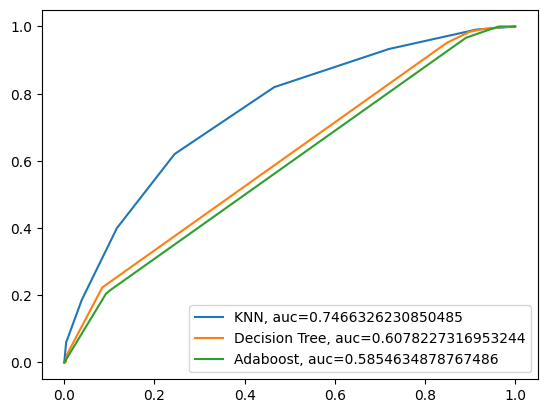

In [26]:
#Plot the ROC curves
tree_fpr, tree_tpr, tree_thresh, tree_auc = roc_auc(DT_tuned_pipeline, X_test, Y_test)
knn_fpr, knn_tpr, knn_thresh, knn_auc = roc_auc(KNN_tuned_pipeline, X_test, Y_test)
ada_fpr, ada_tpr, ada_thresh, ada_auc = roc_auc(ADABOOST_tuned_pipeline, X_test, Y_test)

plt.figure(0).clf()
plt.plot(knn_fpr,knn_tpr,label="KNN, auc="+str(knn_auc))
plt.plot(tree_fpr,tree_tpr,label="Decision Tree, auc="+str(tree_auc))
plt.plot(ada_fpr,ada_tpr,label="Adaboost, auc="+str(ada_auc))

plt.legend(loc=0)

In [27]:
# Updated test case due to verion changes - Source: Piazza 
np.testing.assert_almost_equal(tree_fpr, [0.         ,0.00330852, 0.00661704, 0.08436725, 0.83953681, 0.84946237,
 0.88585608, 0.88585608, 0.89330025, 0.89578164, 0.92886683, 0.95947064,
 0.96691481, 0.99917287, 1.        ])
np.testing.assert_almost_equal(tree_tpr, [0.00000000e+00, 8.39630563e-04, 2.51889169e-02, 2.23341730e-01,
 9.42905122e-01, 9.52141058e-01, 9.75650714e-01, 9.77329975e-01,
 9.79009236e-01, 9.83207389e-01, 9.92443325e-01, 9.95801847e-01,
 9.98320739e-01, 9.98320739e-01, 1.00000000e+00])
np.testing.assert_almost_equal(tree_thresh, [np.inf,         1.,         0.91208791, 0.73289902, 0.49504405, 0.42857143,
 0.29588015, 0.25,       0.16363636, 0.14814815, 0.11724138, 0.08823529,
 0.0625,     0.02054795, 0.        ])

np.testing.assert_almost_equal(ada_fpr, [0.,         0.09263854, 0.10173697, 0.89081886, 0.9611249,  0.96526055,
 0.96691481, 0.99834574, 1.        ])
np.testing.assert_almost_equal(ada_tpr, [0.,         0.20486986, 0.21494542, 0.96641478, 0.99916037, 1.,
 1.,         1.,         1.,        ])
np.testing.assert_almost_equal(ada_thresh, [np.inf, 0.59082288, 0.52068725, 0.49573201, 0.42515557, 0.4220354,
 0.35457358, 0.33206415, 0.27221056])


### 2.2 Intepreting ROC curves

Take a look at the above ROC curves. How are they similar? How do they differ? Is one strictly better than the other? In what situations is one better than the other?

**YOUR ANSWER HERE**

The ROC curves all starts at (0,0) and ends at (1,1). They are also all similar in the fact that all three curves are above the 50/50 diagonal line which would represent random guessing so all three models are better classifiers than complete random guessing. The AUC for KNN is a lot higher than the Decision Tree and the Adaboost model which seems to indicate that the KNN model is better than the other models; however, I do not think the KNN is strictly better than the other models. To be strictly better, the ROC curve should be above the other models for the entire range of FPR but from the ROC curves shown above, there seems to be some overlap at the end. It seems that the KNN model consistently outperforms the other models for most of the FPR range until the end in which the other models may perform the same or outperform the KNN model in the large FPR range.